In [1]:
# Importing liberaries

import pandas as pd 
import numpy as np
from ast import literal_eval  # evaluate strings containing Python code in the current Python environment
from nltk.stem.snowball import SnowballStemmer # Removing stem words
from sklearn.feature_extraction.text import CountVectorizer  # To convert text to numerical data
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn import preprocessing
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from collections import defaultdict
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import seaborn as sns
import networkx as nx

import warnings  # disable python warnings
warnings.filterwarnings("ignore")

In [2]:
movies_data = pd.read_csv("Dataset/movies_metadata.csv", low_memory=False)
credits = pd.read_csv('Dataset/credits.csv')
keywords = pd.read_csv('Dataset/keywords.csv')
links_small = pd.read_csv('Dataset/links_small.csv')
ratings = pd.read_csv("Dataset/ratings_small.csv")

In [3]:
### BASIC RECOMMENDATION SYSTEM

In [4]:
movies_data = movies_data.dropna(subset=['vote_average', 'vote_count'])

In [5]:
#imdb_score movie recommendation
import math

def weighted_rating(v,R):
    
    '''
    
    This function calculate weighted rating of a movies using IMDB formula
    
    Parameters: v (int): vote count
                R (int): vote average
    Returns: (float) IMDB score
    
    '''
    return ((v/(v+m)) * R) + ((m/(m+v)) * C)  

C = movies_data['vote_average'].mean()         # mean vote across all data
m = movies_data['vote_count'].quantile(0.95)   # movies with more than 95% votes is taken (95 percentile)

# Taking movies whose vote count is greater than m
top_movies = movies_data.copy().loc[movies_data['vote_count'] >= m]
top_movies = top_movies.reset_index()

top_movies['score'] = ''

for i in range(top_movies.shape[0]):
    v = top_movies['vote_count'][i]          # number of vote count of the movie
    R = top_movies['vote_average'][i]        # average rating of the movie
    top_movies['score'][i] = weighted_rating(v,R)

top_movies = top_movies.sort_values('score', ascending=False)  # sorting movies in descending order according to score
top_movies = top_movies.reset_index()

# top_movies[['title', 'vote_count', 'vote_average', 'score']].head(20) # top 20 movies
t1 = top_movies[['title', 'score','imdb_id']].head(20)

#popularity based recommendation system

def normalize(data,key):
    min_val = float(min(data[key]))
    max_val = float(max(data[key]))
    
    for i in range(len(data[key])):
        x = data.at[i,key]
        y = (float(x) - min_val) / (max_val - min_val)
        data.at[i,key] = y

normalize(top_movies, 'popularity')

def final_scores(data):
    top_movies['final_score'] = ''
    
    for i in range(len(data)):
        x = math.sqrt(data.at[i,'popularity']*data.at[i,'score'])
        top_movies['final_score'][i] = x

final_scores(top_movies)

top_movies = top_movies.sort_values('final_score', ascending=False)
t2 = top_movies[['title', 'final_score','imdb_id']].head(20)
t2 = t2.reset_index()


In [6]:
# Simple recommender based on genres

genres = set()

# Finding the exhaustive set of genres in the dataset 
top_movies['genres'] = top_movies['genres'].apply(literal_eval)
for i in range(top_movies['genres'].shape[0]):   # converting string in map
    for x in top_movies['genres'][i]:
        genres.add(x['name'])
        
        
# creating map of string (genre name) and movies names(dataframe)
all_genre = []

genres_based = dict()   
for i in range(top_movies['genres'].shape[0]):  
    for x in top_movies['genres'][i]:
        if x['name'] not in genres_based.keys():
            all_genre.append(x['name'])
            genres_based[x['name']] = pd.DataFrame(columns = top_movies.columns)
        genres_based[x['name']] = genres_based[x['name']].append(top_movies.iloc[i]) 

In [7]:

top = genres_based['Comedy']
top = top.sort_values('score', ascending=False)
t4 = top[['title','score','imdb_id']].head(5)
print(t4)

                      title     score    imdb_id
2           The Dark Knight  8.208376  tt0468569
9   The Empire Strikes Back  8.025793  tt0080684
13             Interstellar  8.007315  tt0816692
16   Leon: The Professional  7.962958  tt0110413
21               GoodFellas  7.892593  tt0099685


In [8]:
# Content Based Filtering

movies_data['id'] = movies_data['id'].astype('int')  #converts the all data type into integer

# merging both credits and keywords in movies_data on the basis of movie id
movies_data = movies_data.merge(credits, on='id')
movies_data = movies_data.merge(keywords, on='id')

links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

# taking only those movies whos id is present in link_small because of limited computing power
smd = movies_data[movies_data['id'].isin(links_small)]  
smd = smd.reset_index()

In [9]:
def get_director(x):
    
    '''
    
    This function gives the name of first director occuring in the crew of the movie
    
    Parameters: x(list of dictionary): List containing name and corrosponding role of complete cast of the movie
    
    Returns: (string) It returns the first director name that appear in the list
    
    '''
    
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

# Applying literal_eval to get the right data type from the expression of string
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['genres'] = smd['genres'].apply(literal_eval)
smd['production_countries'] = smd['production_countries'].apply(literal_eval)
smd['production_companies'] = smd['production_companies'].apply(literal_eval)

smd['director'] = smd['crew'].apply(get_director)

# production companies
smd['production_companies'] = smd['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else []) 
smd['production_companies'] = smd['production_companies'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

# production_countries
smd['production_countries'] = smd['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['production_countries'] = smd['production_countries'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

# Taking all the movie cast in a list and then taking only the top 3 cast
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])# Strip Spaces and Convert to Lowercase

# making list of all the keywords 
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# making list of all the genres
smd['genres'] = smd['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['genres'] = smd['genres'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x,x])  # giving more weight to the director relative to the entire cast

# language
smd['original_language'] = smd['original_language'].apply(lambda x: [x])

In [10]:
smd['original_language'].describe


<bound method NDFrame.describe of 0       [en]
1       [en]
2       [en]
3       [en]
4       [en]
        ... 
9214    [en]
9215    [hi]
9216    [hi]
9217    [ja]
9218    [en]
Name: original_language, Length: 9219, dtype: object>

In [11]:
def filter_keywords(x):
    
    '''
    
    This funtion remove those keywords which occur only once 
    
    Parameters: x(list): List containing keywords of the movie
    
    Returns: (list) It returns a list containg only those keywords which are present in keywords_count ( it is a dictionary containg those keywords which occur more than once )
    
    '''    
    
    words = []
    # x is a list keywords for a particular movies
    for i in x:
        # every keywords in a particular movie
        if i in keywords_count.keys():
            words.append(i)
    return words

# Creating the count of every keywords
keywords_count = dict()
for i in range(len(smd['keywords'])): # for(int i=0;i<smd['keywords'].size();i++)
    for j in range(len(smd['keywords'][i])): # for(int j=0;j<smd['keywords'][i].size();j++)
        if smd['keywords'][i][j] not in keywords_count.keys():
            keywords_count[smd['keywords'][i][j]] = 0
        keywords_count[smd['keywords'][i][j]] +=1

# removing those keywords which occur only once
for i in list(keywords_count):
    if keywords_count[i] == 1:
        del keywords_count[i]

In [12]:
# preprocessing

# Stemming the words 
# 
stemmer = SnowballStemmer('english')

smd['keywords'] = smd['keywords'].apply(filter_keywords) # removing those keywords which occur only once
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

# combining keywords, cast, director and genres
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres'] + smd['production_companies'] + smd['production_countries'] + smd['original_language']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [13]:
print(smd['soup'])

0       jealousi toy boy friendship friend rivalri boy...
1       boardgam disappear basedonchildren'sbook newho...
2       fish bestfriend duringcreditssting waltermatth...
3       basedonnovel interracialrelationship singlemot...
4       babi midlifecrisi confid age daughter motherda...
                              ...                        
9214    friendship sidneypoitier wendycrewson jayo.san...
9215    bollywood akshaykumar ileanad'cruz eshagupta t...
9216    bollywood hrithikroshan poojahegde kabirbedi a...
9217    monster godzilla giantmonst destruct kaiju hir...
9218    music documentari paulmccartney ringostarr joh...
Name: soup, Length: 9219, dtype: object


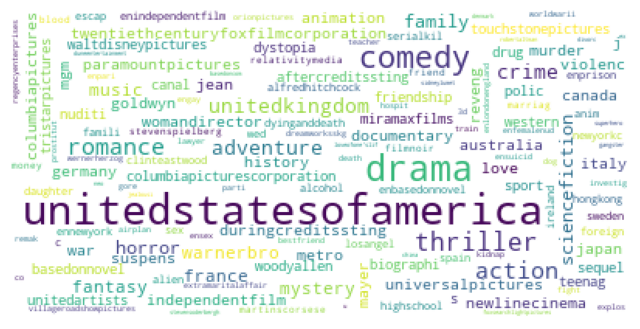

In [14]:
# Creating the Wordcloud for visualisation of the word which occur frequently in the dataset

# Combining all the text contained in smd['soup'] column
text = ""
for i in smd['soup']:
    text +=i
    
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
# plot the WordCloud image                      
plt.figure(figsize = (8, 8))
plt.imshow(word_cloud)
plt.axis("off")
 
plt.show()

In [15]:
smd

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director,soup
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,[en],Toy Story,...,NaN,Toy Story,False,7.7,5415.0,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousi, toy, boy, friendship, friend, rival...","[johnlasseter, johnlasseter, johnlasseter]",jealousi toy boy friendship friend rivalri boy...
1,1,False,NaN,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,[en],Jumanji,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgam, disappear, basedonchildren'sbook, n...","[joejohnston, joejohnston, joejohnston]",boardgam disappear basedonchildren'sbook newho...
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[romance, comedy]",NaN,15602,tt0113228,[en],Grumpier Old Men,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fish, bestfriend, duringcreditssting]","[howarddeutch, howarddeutch, howarddeutch]",fish bestfriend duringcreditssting waltermatth...
3,3,False,NaN,16000000,"[comedy, drama, romance]",NaN,31357,tt0114885,[en],Waiting to Exhale,...,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...","[forestwhitaker, forestwhitaker, forestwhitaker]",basedonnovel interracialrelationship singlemot...
4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[comedy],NaN,11862,tt0113041,[en],Father of the Bride Part II,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[babi, midlifecrisi, confid, age, daughter, mo...","[charlesshyer, charlesshyer, charlesshyer]",babi midlifecrisi confid age daughter motherda...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9214,40948,False,NaN,8000000,[drama],NaN,159550,tt0255313,[en],The Last Brickmaker in America,...,NaN,The Last Brickmaker in America,False,7.0,1.0,"[sidneypoitier, wendycrewson, jayo.sanders]","[{'credit_id': '544475aac3a36819fb000578', 'de...",[friendship],"[greggchampion, greggchampion, greggchampion]",friendship sidneypoitier wendycrewson jayo.san...
9215,41168,False,NaN,1000000,"[thriller, romance]",NaN,392572,tt5165344,[hi],रुस्तम,...,Decorated Officer. Devoted Family Man. Defendi...,Rustom,False,7.3,25.0,"[akshaykumar, ileanad'cruz, eshagupta]","[{'credit_id': '5951baf692514129c4016600', 'de...",[bollywood],"[tinusureshdesai, tinusureshdesai, tinusureshd...",bollywood akshaykumar ileanad'cruz eshagupta t...
9216,41221,False,NaN,15050000,"[adventure, drama, history, romance]",NaN,402672,tt3859980,[hi],Mohenjo Daro,...,NaN,Mohenjo Daro,False,6.7,26.0,"[hrithikroshan, poojahegde, kabirbedi]","[{'credit_id': '57cd5d3592514179d50018e8', 'de...",[bollywood],"[ashutoshgowariker, ashutoshgowariker, ashutos...",bollywood hrithikroshan poojahegde kabirbedi a...
9217,41387,False,NaN,15000000,"[action, adventure, drama, horror, sciencefict...",NaN,315011,tt4262980,[ja],シン・ゴジラ,...,A god incarnate. A city doomed.,Shin Godzilla,False,6.6,152.0,"[hirokihasegawa, yutakatakenouchi, satomiishih...","[{'credit_id': '560892fa92514177550018b2', 'de...","[monster, godzilla, giantmonst, destruct, kaiju]","[hideakianno, hideakianno, hideakianno]",monster godzilla giantmonst destruct kaiju hir...


In [16]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2) ,min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

cosine_sim = cosine_similarity(count_matrix, count_matrix)

titles = smd[['title','imdb_id']]
indices = pd.Series(smd.index, index=titles['title'])  # Creating a mapping between movie and title and index

In [17]:
df_cosine=pd.DataFrame(cosine_sim)
df_cosine

,0,1,2,3,4,5,6,7,8,9,...,9209,9210,9211,9212,9213,9214,9215,9216,9217,9218
0,1.000000,0.081633,0.091502,0.089242,0.083351,0.045948,0.078492,0.099473,0.063888,0.053158,...,0.029788,0.054873,0.039246,0.072442,0.071993,0.102632,0.000000,0.000000,0.000000,0.068626
1,0.081633,1.000000,0.068626,0.066932,0.062514,0.045948,0.058869,0.124341,0.085184,0.070877,...,0.029788,0.054873,0.058869,0.072442,0.053995,0.076974,0.000000,0.022875,0.020838,0.068626
2,0.091502,0.068626,1.000000,0.125039,0.093428,0.068670,0.109976,0.083624,0.071611,0.059584,...,0.033389,0.061507,0.021995,0.081200,0.080697,0.086280,0.027875,0.025641,0.000000,0.076923
3,0.089242,0.066932,0.125039,1.000000,0.091121,0.066974,0.107261,0.108745,0.069843,0.058113,...,0.032564,0.079984,0.042904,0.105593,0.078704,0.112199,0.027186,0.050016,0.022780,0.075023
4,0.083351,0.062514,0.093428,0.091121,1.000000,0.046915,0.100180,0.076176,0.065233,0.054277,...,0.030415,0.056028,0.020036,0.073967,0.073509,0.078594,0.000000,0.000000,0.000000,0.070071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9214,0.102632,0.076974,0.086280,0.112199,0.078594,0.077023,0.074012,0.125061,0.080322,0.066832,...,0.037450,0.091984,0.049341,0.121435,0.067884,1.000000,0.000000,0.028760,0.026198,0.086280
9215,0.000000,0.000000,0.027875,0.027186,0.000000,0.018663,0.023911,0.000000,0.025950,0.021592,...,0.000000,0.022288,0.000000,0.029424,0.000000,0.000000,1.000000,0.139374,0.000000,0.000000
9216,0.000000,0.022875,0.025641,0.050016,0.000000,0.017168,0.021995,0.083624,0.023870,0.019861,...,0.000000,0.020502,0.065986,0.027067,0.000000,0.028760,0.139374,1.000000,0.070071,0.000000
9217,0.000000,0.020838,0.000000,0.022780,0.000000,0.031277,0.000000,0.126959,0.065233,0.036185,...,0.000000,0.018676,0.140253,0.024656,0.055132,0.026198,0.000000,0.070071,1.000000,0.000000


<AxesSubplot: >

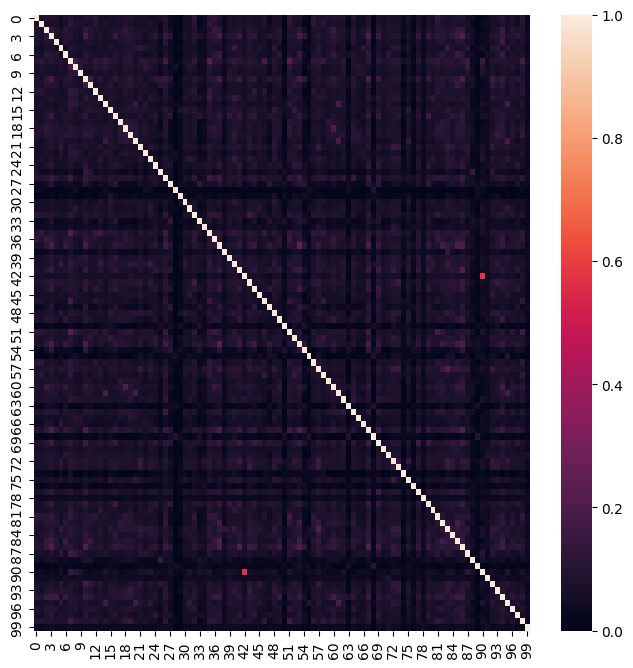

In [18]:
# Creating Heatmap for visualization of correlation between different movies 

#specify size of heatmap
fig, ax = plt.subplots(figsize=(8, 8))

#create seaborn heatmap of only top 100 movies
sns.heatmap(cosine_sim[:100,:100])

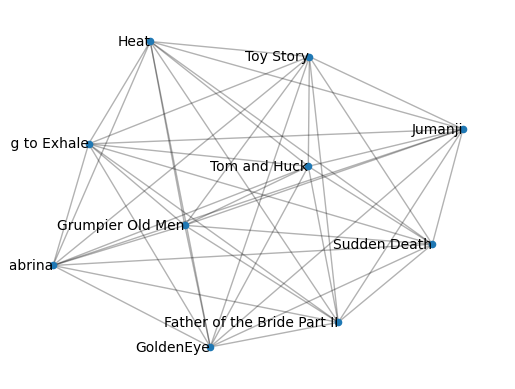

In [19]:
# Graph structure to visualize similarity relation between selected movies

g = nx.Graph()
n = 10

for i in range(n):
    g.add_node(titles['title'][i])

for i in range(n):
    for j in range(n):
        if i != j and cosine_sim[i][j]>0:
            g.add_edge(titles['title'][i],titles['title'][j],weight = cosine_sim[i][j])
    
g = g.to_undirected()
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, node_size = 20)
nx.draw_networkx_edges(g, pos,alpha = 0.3)
nx.draw_networkx_labels(g, pos, font_size=10, horizontalalignment="right")

plt.axis("off")
plt.show()

In [20]:
def get_recommendations(title):
    idx = indices[title] # movie id corrosponding to the given title 
    sim_scores = list(enumerate(cosine_sim[idx])) # list of cosine similarity scores value along the given index
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # sorting the given scores in ascending order
    sim_scores = sim_scores[1:31] # Taking only the top 30 scores
    movie_indices = [i[0] for i in sim_scores] # Finding the indices of 30 most similar movies
    return titles.iloc[movie_indices] 

t3 = get_recommendations('The Dark Knight').head(5)
t3.reset_index()
print(t3)

                      title    imdb_id
6218          Batman Begins  tt0372784
8031  The Dark Knight Rises  tt1345836
7648              Inception  tt1375666
6623           The Prestige  tt0482571
2085              Following  tt0154506


In [23]:
from tkinter import *
import pandas as pd
from tkinter import ttk
from matplotlib import pyplot as plt
from PIL import Image, ImageTk
from urllib.request import urlopen
import requests

win = Tk()
win.title('Movie Recommender System')

#Set the geometry of tkinter frame
win.geometry("900x900")
win.configure(bg="#008080")

#reading the CSVs
data_csv = pd.read_csv("Dataset/movies_metadata.csv",low_memory=False)

Movies = smd['title']
Movie_Image_List = data_csv['poster_path']
# movie_ids = data_csv['imdb_id']

poster_urls = []
movie_ids = []
poster_urls_id = []

def recommend(movies):
    #loading spinner
    # spinner = ttk.Progressbar(win, orient=HORIZONTAL, length=200, mode='indeterminate')
    # spinner.grid(row=2, column=1, padx=5, pady=5)
    # spinner.start()
    
    poster_urls = []
    movie_ids = []
    
    for index, row in movies.iterrows():
        x = row['imdb_id']
        movie_ids.append(x)

    CONFIG_PATTERN = 'http://api.themoviedb.org/3/configuration?api_key={key}'
    KEY = '3e982460412cce495589b8ef26282d84'

    url = CONFIG_PATTERN.format(key=KEY)
    r = requests.get(url)
    config = r.json()

    def poster_func(movie_id):
        base_url = config['images']['base_url']
        sizes = config['images']['poster_sizes']
        IMG_PATTERN = 'http://api.themoviedb.org/3/movie/{imdbid}/images?api_key={key}'
        r = requests.get(IMG_PATTERN.format(key=KEY,imdbid=movie_id))
        api_response = r.json()

        rel_path = api_response['posters'][0]['file_path']
        poster_url = base_url + 'w92' + rel_path
        
        poster_urls.append(poster_url)

    for i in range(len(movie_ids)):
        try:
            poster_func(movie_ids[i])
        except:
            print("error")
            
    poster_urls_id = []
            
    for i in range(len(poster_urls)):
        try:
            image_url = poster_urls[i]
            u = urlopen(image_url)
            raw_data = u.read()
            u.close()
            poster_urls_id.append(raw_data)
        except:
            print("error")
            
    # spinner.stop()
            
    photo1 = ImageTk.PhotoImage(data=poster_urls_id[0])
    label1.config(image = photo1)
    label1.image = photo1
    
    photo2 = ImageTk.PhotoImage(data=poster_urls_id[1])
    label2.config(image = photo2)
    label2.image = photo2
    
    photo3 = ImageTk.PhotoImage(data=poster_urls_id[2])
    label3.config(image = photo3)
    label3.image = photo3
    
    photo4 = ImageTk.PhotoImage(data=poster_urls_id[3])
    label4.config(image = photo4)
    label4.image = photo4
    
    photo5 = ImageTk.PhotoImage(data=poster_urls_id[4])
    label5.config(image = photo5)
    label5.image = photo5

# upadates
def recommend_btn():
    if selected_item.get() == "Basic Recommender System":
        if selected_types.get() == "IMDB Rating":
            recommend(t1)
        elif selected_types.get() == "Genre Based":
            top_movies = genres_based[selected_genre.get()]
            top_movies = top_movies.sort_values('score', ascending=False)
            t4 = top_movies[['title','score','imdb_id']].head(5)
            print(t4)
            t4.reset_index()
            recommend(t4)
        else:
            recommend(t2)
    else:
        recommend(get_recommendations(my_entry.get()).head(5))
        
def update(Movies):
    my_list.delete(0, END)
    for movie in Movies:
        my_list.insert(END, movie)

def fillout(e):
    my_entry.delete(0,END)
    my_entry.insert(0,my_list.get(ACTIVE))

def check(e):
    typed = my_entry.get()

    if typed == '':
        data = Movies
    else: 
        data = []
        for movie in Movies:
            if typed.lower() in movie.lower():
                data.append(movie)
    update(data)

#creating Frame
frame1 = Frame(win)

# Recommendation System Types
selected_item = StringVar()
options = ['Basic Recommender System', 'Content Based Recommender System']
combo = ttk.Combobox(frame1,textvariable=selected_item, values=options)

def system_selected(*args):
    if selected_item.get() == "Basic Recommender System":
        my_entry.pack_forget()
        my_list.pack_forget()
        genre_box.pack_forget()
        combo1.pack()
    else:
        my_entry.pack()
        my_list.pack()
        genre_box.pack_forget()
        combo1.pack_forget()
    
combo.bind("<<ComboboxSelected>>", system_selected)
combo.pack()

# Recommendation Types
selected_types = StringVar()
options = ['IMDB Rating', 'Genre Based', 'Popularity']
combo1 = ttk.Combobox(frame1, textvariable=selected_types, values=options)

def type_selected(*args):
    if selected_types.get() == "Genre Based":
        genre_box.pack()
    else:
        genre_box.pack_forget()

combo1.bind("<<ComboboxSelected>>", type_selected)
combo1.pack_forget()

#search heading
my_label = Label(frame1,text="Search For Movie...", font=("Helvetica", 11), fg = "#81cdc6", bg = "#008080")
my_label.pack(pady=20)

#search Box
my_entry = Entry(frame1,font=("Helvetica", 10),bg=("#81cdc6"),width=50)
my_entry.pack()

#list of movies
my_list = Listbox(frame1,font=("Helvetica", 10),bg=("#81cdc6"),width=50)
my_list.pack()

#genre dropdown box
genres = all_genre
selected_genre = StringVar()
genre_box = ttk.Combobox(frame1,textvariable=selected_genre, values=genres)
genre_box.pack_forget()

#search button
button = Button(frame1, text="Search", command=recommend_btn)
button.pack()

frame1.pack(side=LEFT,expand=True,fill=BOTH)

#showing posters
frame2 = Frame(win)

# print(poster_urls)
label1 = Label(frame2)
label1.pack()

label2 = Label(frame2)
label2.pack()

label3 = Label(frame2)
label3.pack()

label4 = Label(frame2)
label4.pack()

label5 = Label(frame2)
label5.pack()
    
frame2.pack(side=LEFT,expand=True,fill=BOTH)

#update
update(Movies)
my_list.bind("<<ListboxSelect>>", fillout)
my_entry.bind("<KeyRelease>", check)

# button = tk.Button(root, text="Run App", command=run_app)
# button.pack()

win.mainloop()

                   title     score    imdb_id
38                  Room  7.770814  tt3170832
72           Rear Window  7.629772  tt0047396
85         Hacksaw Ridge  7.546004  tt2119532
93    My Neighbor Totoro  7.522321  tt0096283
139  Million Dollar Baby  7.394041  tt0405159
